# Feasible Space Dubins Car

The Dubins car problem is non-holonomic, and while each configuration is possible, the manner in which those configurations can be reached is reduced. Notably we have $$\dot y \cos \theta - \dot x \sin \theta = 0$$

Hence, unlike for the other examples we cannot rely on the linearized LQR controller to act as performance / nominal controller. Instead we solve the reachability problem for reaching a target (without accounting for the obstacle avoidance) and use the found policy as the performance policy.

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys; sys.version

'3.11.5 (main, Aug 25 2023, 13:19:53) [GCC 9.4.0]'

In [9]:
import sys
sys.path.append('/home/dasc/hardik/social-navigation/refineCBF')


In [10]:
import refine_cbfs
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment
from dubins import nominal_hjr_control

In [11]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '80',
    'text.usetex': False,   # Toggle to true for official LaTeX output
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})
import matplotlib.animation as anim

params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

## Setup Problem (dynamics, environment and CBF)

### Parameter values

Dynamics properties

In [12]:
dubins_vel = 1.0  # m / s 
umin = np.array([-0.5])  # rad / s
umax = np.array([0.5])  # rad / s 
dt = 0.05 # s

Constraint set of the problem. Single rectangular constraint in the $(x,y)$ space

In [13]:
obstacle_center = np.array([5.0, 5.0])
obstacle_length = np.array([2.0, 2.0])

### Dynamics

Dynamics of the Dubins car problem (control affine), with fixed velocity $v$ in the format of `cbf_opt`

`DubinsJNPDynamics` is required for usage with `hj_reachability` module

In [14]:
class DubinsDynamics(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']
    
    def __init__(self, params, test = False, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1
        params["periodic_dims"] = [2]
        self.v = params["v"]
        super().__init__(params, test, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = self.v * np.cos(state[..., 2])
        f[..., 1] = self.v * np.sin(state[..., 2])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 2, 0] = 1
        return B

    def disturbance_jacobian(self, state, time=0.0):
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 2] = -self.v * np.sin(state[..., 2])
        J[..., 1, 2] = self.v * np.cos(state[..., 2])
        return J
        
class DubinsJNPDynamics(DubinsDynamics):
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([self.v * jnp.cos(state[2]), self.v * jnp.sin(state[2]), 0])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, -self.v * jnp.sin(state[2])],
            [0, 0, self.v * jnp.cos(state[2])], 
            [0, 0, 0]])

In [15]:
dyn = DubinsDynamics({"v": dubins_vel, "dt": dt}, test=True)
dyn_jnp = DubinsJNPDynamics({"v": dubins_vel, "dt": dt}, test=True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Initial Control Barrier Function

Below is a candidate CBF, however as the Dubins car with obstacles in $x,y$ has relative degree $2$, the CBF cannot be enforced online as the CBF constraint does not feature the input (steering rate)

This CBF inflate the rectangular obstacle to a circle obstacle, as is typically done to preserve convexity

In [16]:
class DubinsCBF(ControlAffineCBF):
    def __init__(self, dynamics: DubinsDynamics, params: dict = dict(), **kwargs) -> None:
        self.center = params["center"]
        self.r = params["r"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return (state[..., 0] - self.center[0]) ** 2 + (state[..., 1] - self.center[1]) ** 2 - self.r ** 2

    def _grad_vf(self, state, time=0.0):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 0] = 2 * (state[..., 0] - self.center[0])
        dvf_dx[..., 1] = 2 * (state[..., 1] - self.center[1])
        return dvf_dx

In [17]:
obstacle_length

array([2., 2.])

In [18]:
dubins_cbf = DubinsCBF(dyn, {"center": obstacle_center, "r": np.sqrt(np.max(obstacle_length))}, test=True)

### Environment
Defining the discretized state space and the location of obstacles

In [19]:
dyn_hjr = refine_cbfs.dynamics.HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

state_domain = hj.sets.Box(lo=jnp.array([-5., -5., -jnp.pi]), hi=jnp.array([20., 20., jnp.pi]))
grid_resolution = (201, 201, 81)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

In [20]:
def constraint_set(state):
    """A real-valued function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """

    # Construct Au>= b matrix

    
    
    # # obstacle 1 
    # obs1 = np.array([2.0,2.0])
    # obs2 = np.array([1.0,3.0])
    # obs3 = np.array([2.7,3.0])
    
    bottom_left = jnp.array(obstacle_center - obstacle_length / 2)
    length = obstacle_length
    return -jnp.min(jnp.array([state[0] - bottom_left[0], bottom_left[0] + length[0] - state[0], 
                               state[1] - bottom_left[1], bottom_left[1] + length[1] - state[1]]))

In [21]:
obstacle = hj.utils.multivmap(constraint_set, jnp.arange(grid.ndim))(grid.states)  # l(x)

## Refining the CBF using Dynamic Programming

In [22]:
dubins_tabular_cbf = refine_cbfs.TabularControlAffineCBF(dyn, dict(), grid=grid)
dubins_tabular_cbf.tabularize_cbf(dubins_cbf)

In [23]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle))

Classically, we solve the reachability problem by initializing the value function with the obstacle set, as below:

In [25]:
init_value = obstacle
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)

target_values_hjr = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
np.save("dubins/hjr_vfs2.npy", target_values_hjr)

100%|###########################################################| 10.0000/10.0 [01:00<00:00,  6.08s/sim_s]


In our work, we propose instead initializing with a candidate CBF, as below:

In [26]:
init_value = dubins_tabular_cbf.vf_table 
times = jnp.linspace(time, target_time, 101)

target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
np.save('dubins/cbf_vfs2.npy', target_values)

100%|###########################################################| 10.0000/10.0 [01:00<00:00,  6.04s/sim_s]


In [27]:
tabular_cbf = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf.vf_table = np.array(target_values[-1])

## Running an experiment (Same as the Paper)

In [28]:
x0 = np.array([2, 4, np.pi / 3])
n_sims_per_start = 1
t_sim = 6

### Setting up the nominal controller
Setting up the nominal controller is non-trivial as outlined in the first section of the notebook

We use HJ reachability instead (but any other nominal controller that can handle non-holonomic constraints, e.g. RRT* could be used)

In [29]:
target = np.array([6, 7, 0])

opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr, grid, final_time=-30, time_intervals=101, solver_accuracy="low", 
                                                  target=target, padding=jnp.array([.2, .2, jnp.pi / 6]))

opt_ctrl.solve()
np.save("dubins/performance_policy_vfs2.npy", opt_ctrl.tv_vf)
    
nom_policy = nominal_hjr_control.NominalPolicy(opt_ctrl)

100%|###########################################################| 30.0000/30.0 [00:48<00:00,  1.61s/sim_s]


### Setting up the safety filter

In [30]:
alpha = lambda x: 5 * x
dubins_asif = ControlAffineASIF(dyn, dubins_cbf, alpha=alpha, nominal_policy=nom_policy)
dubins_asif_ws = ControlAffineASIF(dyn, tabular_cbf, alpha=alpha, nominal_policy=nom_policy, umin=umin, umax=umax)

### Rollout different CBFs / nominal controller

In [31]:
experiment = RolloutTrajectory('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [32]:
import logging
import pandas as pd
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(dyn, {'Nominal': nom_policy, 'Analytical': dubins_asif, 'Refined': dubins_asif_ws})

Controller rollout: 100%|███████████████████████████████████████████████| 120/120 [00:15<00:00,  7.77it/s]


### Visualizing the results

In [33]:
ts_experiment = TimeSeriesExperiment('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment = StateSpaceExperiment('dubins', x_indices=[0, 1], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

Next, we remove the part of the trajectory that is beyond the target! (Dubins car can't stabilize so we consider a finite-time reaching scenario)

In [34]:
updated_df = results_df.copy()
for ctrl in updated_df.controller.unique():
    df = updated_df[(updated_df.controller == ctrl) & (updated_df.measurement == 'dist_to_goal')]
    min_val = df.value.min()
    t_min = df.t.loc[df.value == df.value.min()].values[0]
    condition = updated_df[(updated_df.controller == ctrl) & (updated_df.t > t_min)]
    updated_df = updated_df.drop(condition.index)
updated_df = updated_df.reset_index(drop=True)

## Visualizations for paper + demo + videos

### Figure in paper

In [35]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]

alt_colors = sns.color_palette("pastel", 9).as_hex()

In [36]:
save_figure = False
offset = 0

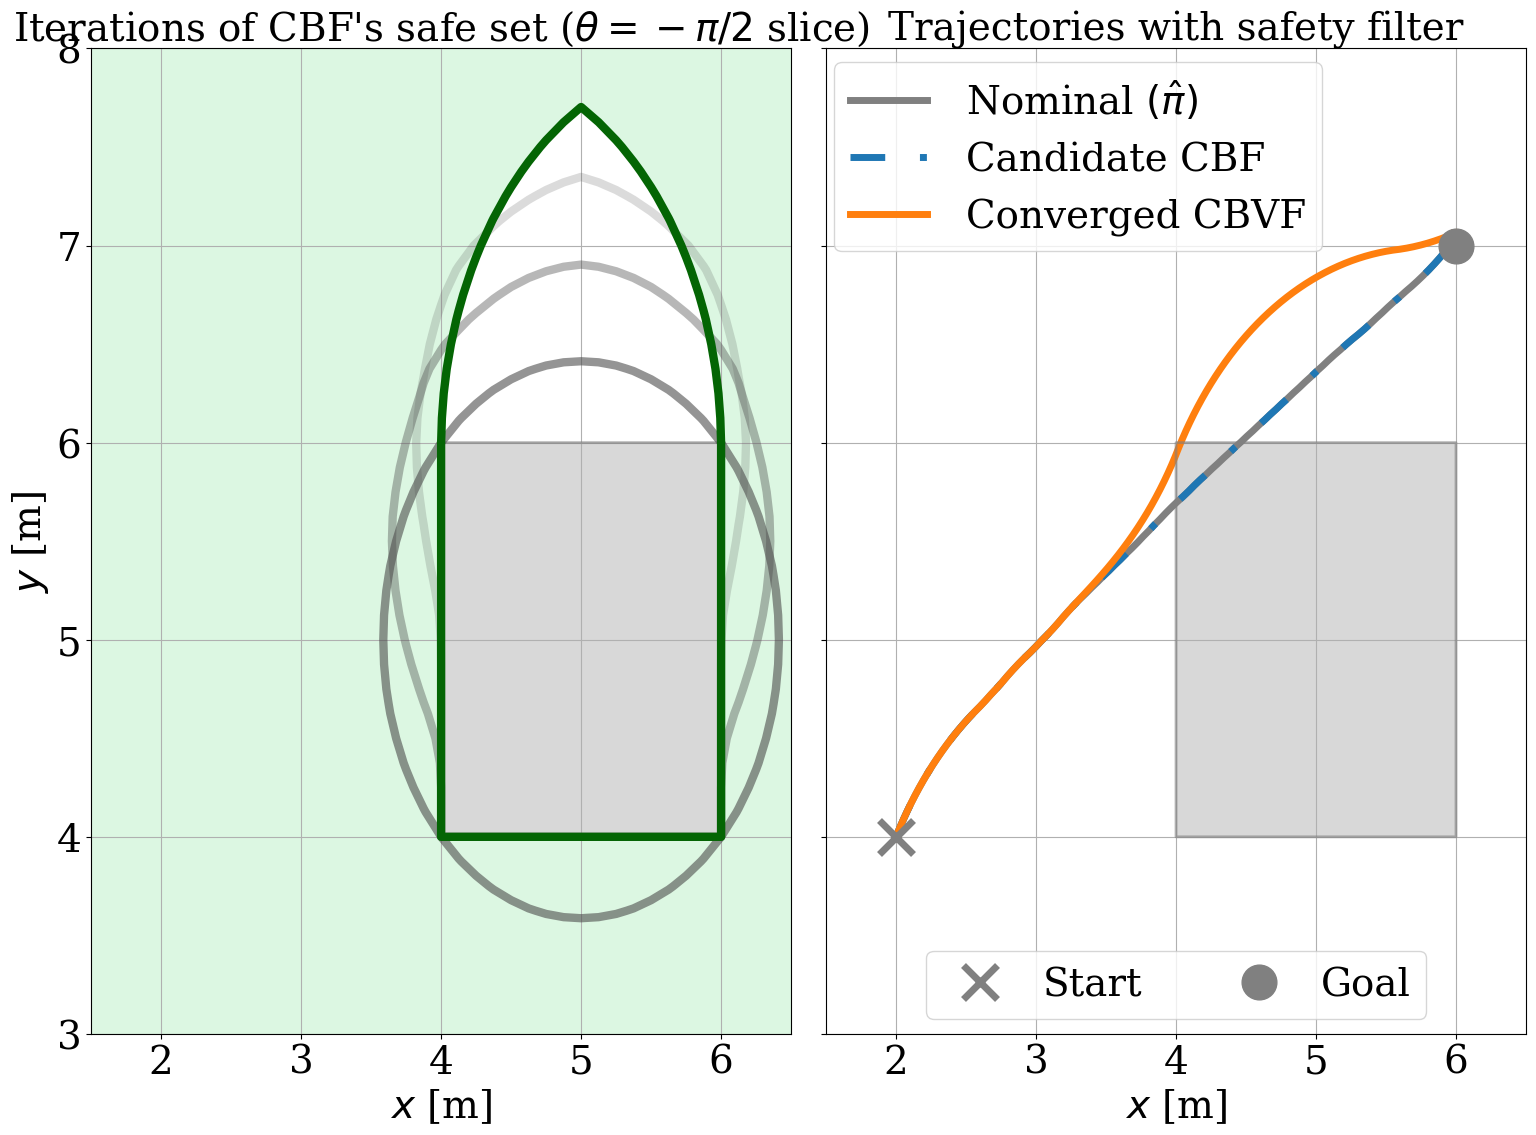

In [37]:
fig_comb, axs = plt.subplots(1, 2, figsize=(16, 12 ), sharey=True)
proxy = [] 
ax=axs[0]

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], 
                 levels=[-10, 0], alpha=0.3, colors='grey')
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], 
           levels=[0], alpha=0.6, colors='grey', linewidths=2)
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., offset], 
                 levels=[0, 50], colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[0][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.6)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[5][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.4)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[10][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.2)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[-1][..., offset], levels=[0], colors=np.array([colors[-1]]), linewidths=6)

ax.grid()
ax.set_xlabel("$x$ [m]")
ax.set_ylabel('$y$ [m]')
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
ax.set_title(r"Iterations of CBF's safe set ($\theta=-\pi / 2$ slice)")
ax = axs[1]
ss_experiment.plot(dyn, updated_df, ax=ax, color=chosen_colors, add_direction=False)
ax.grid(True)
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
ax.lines[3].set_linestyle((0, (5, 5, 1, 5)))
pal = sns.color_palette("colorblind")
sns.set_palette("colorblind")

l1 = ax.plot(x0[0], x0[1], 'x', markersize=25, mew=5, color='grey')
l2 = ax.plot(opt_ctrl.target[0], opt_ctrl.target[1], 'o', markersize=25, color='grey', alpha=1)
miscs = [l1, l2]
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., 0], levels=[-10, 0], 
            colors='grey', alpha=.3)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., 0], levels=[0], 
           colors='grey', alpha=.6, linewidths=2)
ax.set_ylabel(None)
ax.set_xlabel("$x$ [m]")
axs[1].set_title('Trajectories with safety filter')
leg = axs[1].legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.05], loc='center', 
                    frameon=True, handletextpad=0.6)
axs[1].legend([ax.lines[0], ax.lines[3], ax.lines[6]], [r"Nominal $(\hat \pi)$", "Candidate CBF", "Converged CBVF"], 
               bbox_to_anchor=[.36, 0.89], ncol=1, columnspacing=1.5, handletextpad=1, loc='center', frameon=True)
axs[1].add_artist(leg)

fig_comb.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)

if save_figure:
    plt.savefig("dubins.png", dpi=400, bbox_inches='tight')


### Animation of 0-superlevel set

In [38]:
toggle_hjr_visualization = False
save_video = False
offset = 21

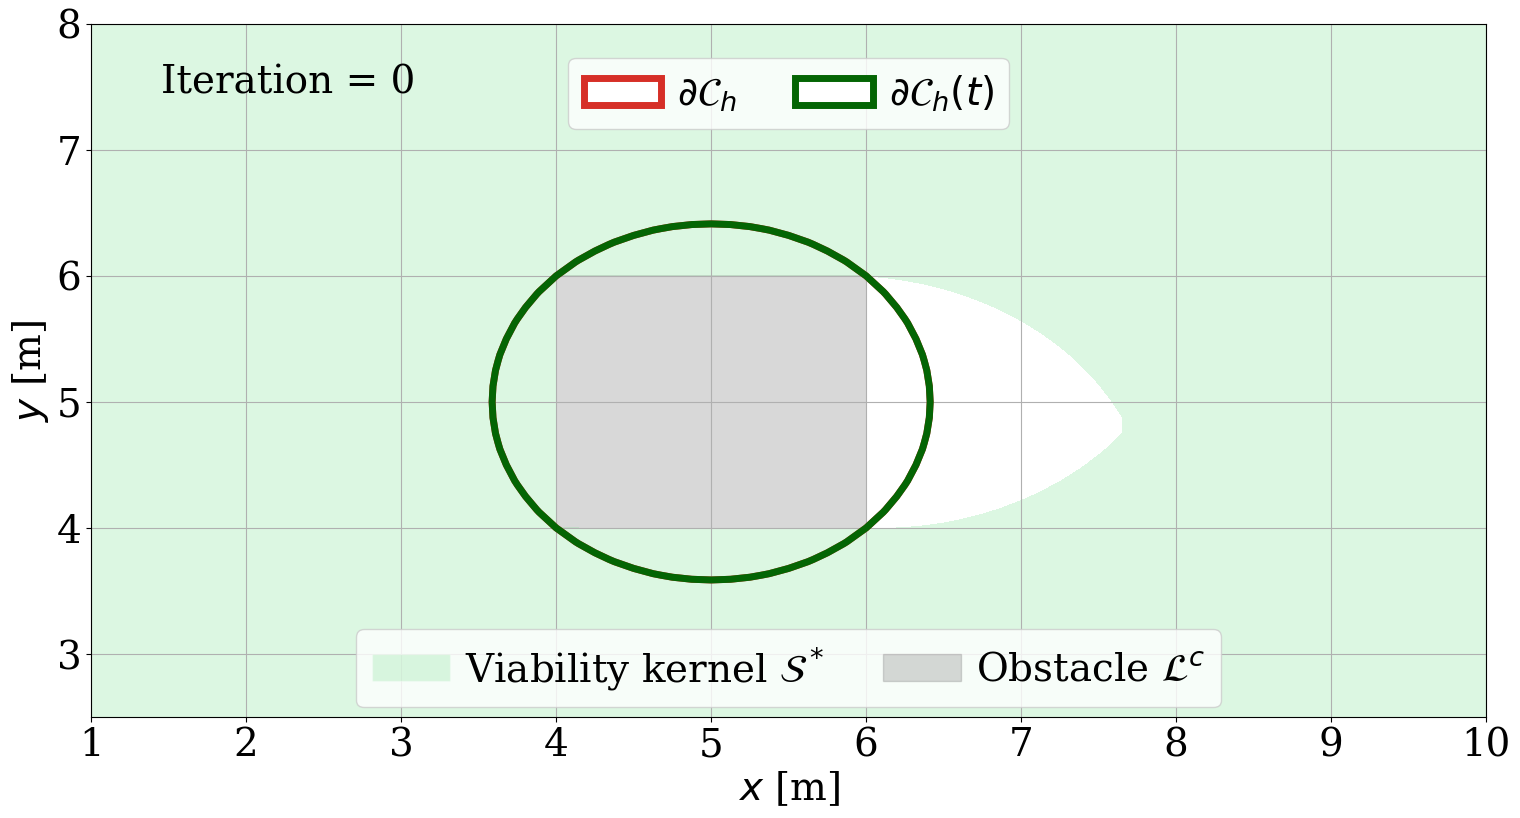

In [39]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()

    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[i][..., offset], levels=[0], 
                      colors=np.array([colors[-1]]))
    if toggle_hjr_visualization:
        global cont2
        for c in cont2.collections:
            c.remove()
        cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[i][..., offset], levels=[0],
                           colors=np.array([chosen_colors[0]]))


filename = "dubins.mp4"
fig, ax = plt.subplots(1, 1, figsize=(18,9 ))

proxy = [] 
obstacle_viz = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], 
                           levels=[-10, 0], colors='grey', alpha=0.3)

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., offset], levels=[0, 50], 
                 colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], 
                  colors=np.array([colors[3]]))
proxy += [plt.Rectangle((0,0),1,1,ec = colors[3], fc='white', lw=5)
        for pc in cont.collections]

timestamp = ax.text(0.05, 0.9, "", transform=ax.transAxes)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], 
                  colors=np.array([colors[-1]]))
proxy += [plt.Rectangle((0,0),1,1,ec = colors[-1], fc='white', lw=5)
          for pc in cont.collections]
if toggle_hjr_visualization:
    cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[0][..., offset], levels=[0], 
                       colors=np.array([chosen_colors[0]]))
    proxy += [plt.Rectangle((0,0),1,1,ec = chosen_colors[0], fc='white', lw=5)
              for pc in cont2.collections]

ax.grid()
ax.set_xlabel("$x$ [m]")
ax.set_xlim([1, 10])
ax.set_ylim([2.5, 8])
ax.set_ylabel("$y$ [m]")

proxy2 = []
proxy2 += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3) for pc in cs.collections]
proxy2 += [plt.Rectangle((0,0),1,1, fc='grey', ec='grey', alpha=0.3) for pc in obstacle_viz.collections]

legend_entries = ["$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$"]
if toggle_hjr_visualization:
    legend_entries += ["$\partial \mathcal{C}_{\ell}(t)$"]
leg = ax.legend(proxy, legend_entries, 
          loc='center', bbox_to_anchor=(0.5, 0.9), ncol=3, columnspacing=1.5, handletextpad=0.4)
ax.legend(proxy2, ["Viability kernel $\mathcal{S}^*$", "Obstacle $\mathcal{L}^c$"],
          loc='center', bbox_to_anchor=(0.5, 0.07), ncol=3, columnspacing=1.5, handletextpad=0.4)
ax.add_artist(leg)


render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, target_values.shape[0] * 5 // 16, interval=100)

if save_video: 
    animation.save(filename, writer='ffmpeg')